# 16.1 Regression Discontinuity Design Intuition

**Chapter**: 16 - Regression Discontinuity Design  
**Section**: 1 - The Core Intuition  
**Facure Source**: 16-Regression-Discontinuity-Design.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Artificial Jumps in Nature](#11-artificial-jumps-in-nature)
   - 1.2 [Is Alcohol Killing You?](#12-is-alcohol-killing-you)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The RDD Setup](#21-the-rdd-setup)
   - 2.2 [Local Randomization Interpretation](#22-local-randomization-interpretation)
   - 2.3 [Sharp vs. Fuzzy RDD](#23-sharp-vs-fuzzy-rdd)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [MLDA and Mortality Data](#31-mlda-and-mortality-data)
   - 3.2 [Visualizing the Discontinuity](#32-visualizing-the-discontinuity)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: RDD is considered the "gold standard" among quasi-experimental methods. Understanding when it provides credible causal inference—and its limitations—is essential for senior DS/Econ roles.

### 1.1 Artificial Jumps in Nature

Facure's poetic observation: **Nature is smooth. When we see jumps, they're probably man-made.**

Examples of artificial discontinuities:
- Age thresholds: Drinking age (21), voting age (18), retirement (65)
- Test score cutoffs: College admission, graduation requirements
- Income thresholds: Tax brackets, welfare eligibility
- Geographic boundaries: School districts, electoral boundaries

These artificial jumps create **natural experiments**: people just above and just below the threshold are essentially comparable, but one group receives treatment.

### 1.2 Is Alcohol Killing You?

Facure's example: **The Minimum Legal Drinking Age (MLDA) and mortality.**

In the US, the legal drinking age is 21. This creates a sharp discontinuity:
- Just under 21: Cannot legally drink
- Just over 21: Can legally drink

**Key insight**: At exactly 21, what determines whether someone is barely under or barely over? Birth date—essentially random. This provides a "local randomized experiment."

★ Insight ─────────────────────────────────────
- RDD exploits discontinuities in treatment assignment
- Near the cutoff, treatment is "as-if" randomly assigned
- Effect is identified only at the cutoff (LATE interpretation)
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The RDD Setup

**Components**:
- $R_i$: Running variable (also called "forcing variable" or "score")
- $c$: Cutoff/threshold
- $D_i$: Treatment indicator
- $Y_i$: Outcome

**Sharp RDD**: Treatment is a deterministic function of the running variable:

$$D_i = \mathbf{1}\{R_i \geq c\}$$

The probability of treatment jumps from 0 to 1 at the cutoff.

**Key Assumption (Continuity)**: The conditional expectation functions $E[Y_0|R=r]$ and $E[Y_1|R=r]$ are continuous at $r = c$.

$$\lim_{r \to c^-} E[Y_0|R=r] = \lim_{r \to c^+} E[Y_0|R=r]$$
$$\lim_{r \to c^-} E[Y_1|R=r] = \lim_{r \to c^+} E[Y_1|R=r]$$

### 2.2 Local Randomization Interpretation

**Proposition (RDD Identification)**: Under the continuity assumption, the treatment effect at the cutoff is:

$$\tau_{\text{RDD}} = \lim_{r \to c^+} E[Y|R=r] - \lim_{r \to c^-} E[Y|R=r]$$

**Proof**:

$$\tau_{\text{RDD}} = \lim_{r \to c^+} E[Y|R=r] - \lim_{r \to c^-} E[Y|R=r]$$

Since $D=1$ for $R > c$ and $D=0$ for $R < c$:

$$= \lim_{r \to c^+} E[Y_1|R=r] - \lim_{r \to c^-} E[Y_0|R=r]$$

By continuity of $E[Y_1|R=r]$ at $c$:

$$= E[Y_1|R=c] - \lim_{r \to c^-} E[Y_0|R=r]$$

By continuity of $E[Y_0|R=r]$ at $c$:

$$= E[Y_1|R=c] - E[Y_0|R=c]$$

$$= E[Y_1 - Y_0|R=c] \quad \blacksquare$$

**Interpretation**: $\tau_{\text{RDD}}$ is a **Local Average Treatment Effect (LATE)** at the cutoff.

### 2.3 Sharp vs. Fuzzy RDD

| Feature | Sharp RDD | Fuzzy RDD |
|---------|-----------|----------|
| Treatment rule | $D = \mathbf{1}\{R \geq c\}$ | $P(D=1|R)$ jumps at $c$ |
| Jump magnitude | 0 → 1 | 0.3 → 0.8 (for example) |
| Estimation | OLS | IV (threshold as instrument) |
| Interpretation | ATE at cutoff | LATE for compliers at cutoff |

**Fuzzy RDD**: Treatment probability jumps but doesn't go from 0 to 1. Think of the threshold as an **instrument** that shifts treatment probability.

★ Insight ─────────────────────────────────────
- Sharp RDD: Cutoff perfectly determines treatment
- Fuzzy RDD: Cutoff increases treatment probability (like IV)
- Both require continuity of potential outcomes at cutoff
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 MLDA and Mortality Data

Following Carpenter and Dobkin (2009), we examine how the legal drinking age affects mortality rates.

In [2]:
# Load MLDA mortality data
drinking = load_facure_data('drinking.csv')

# Center running variable at cutoff (age 21)
drinking['age_centered'] = drinking['agecell'] - 21

# Create treatment indicator (above 21)
drinking['above_21'] = (drinking['age_centered'] >= 0).astype(int)

print(f"Sample: {len(drinking)} age cells")
print(f"Age range: {drinking['agecell'].min():.1f} to {drinking['agecell'].max():.1f}")
print(f"Cutoff: Age 21 (centered at 0)")
print(f"\nOutcome variables:")
print(f"  - all: Deaths by all causes (per 100,000)")
print(f"  - mva: Deaths by motor vehicle accidents")
print(f"  - suicide: Deaths by suicide")
print(f"\nFirst few rows:")
drinking[['agecell', 'age_centered', 'above_21', 'all', 'mva', 'suicide']].head()

Sample: 50 age cells
Age range: 19.1 to 22.9
Cutoff: Age 21 (centered at 0)

Outcome variables:
  - all: Deaths by all causes (per 100,000)
  - mva: Deaths by motor vehicle accidents
  - suicide: Deaths by suicide

First few rows:


,agecell,age_centered,above_21,all,mva,suicide
0,19.0685,-1.9315,0,92.8254,35.8293,11.2037
1,19.1507,-1.8493,0,95.1007,35.6393,12.1934
2,19.2329,-1.7671,0,92.1443,34.2056,11.7158
3,19.3151,-1.6849,0,88.4278,32.2790,11.2750
4,19.3973,-1.6027,0,88.7049,32.6510,10.9843


### 3.2 Visualizing the Discontinuity

The RDD "picture" is the most important diagnostic: **Is there a visible jump at the cutoff?**

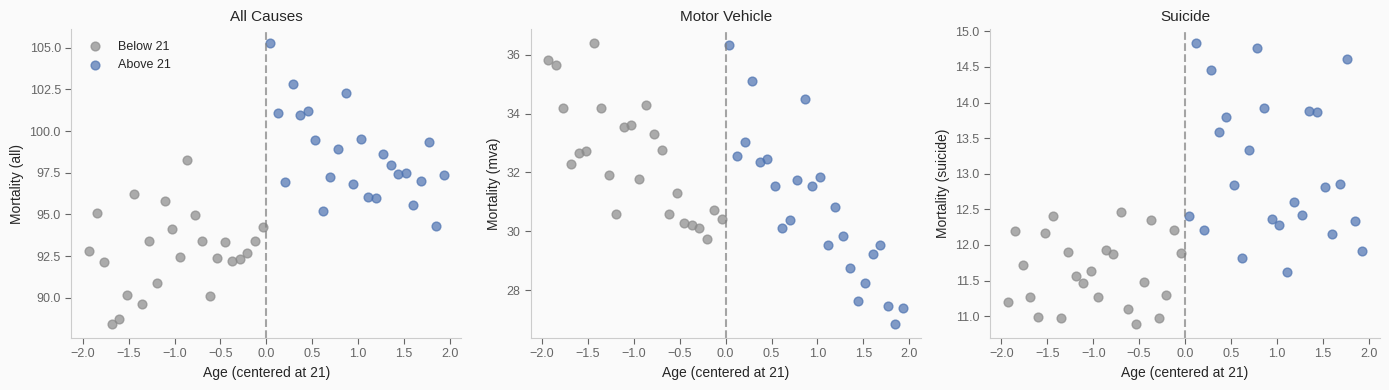

In [3]:
# Visualize discontinuities in mortality outcomes
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

outcomes = [('all', 'All Causes'), ('mva', 'Motor Vehicle'), ('suicide', 'Suicide')]

for ax, (col, title) in zip(axes, outcomes):
    # Scatter plot
    below = drinking[drinking['above_21'] == 0]
    above = drinking[drinking['above_21'] == 1]
    
    ax.scatter(below['age_centered'], below[col], 
               c=TUFTE_PALETTE['control'], s=40, alpha=0.7, label='Below 21')
    ax.scatter(above['age_centered'], above[col], 
               c=TUFTE_PALETTE['treatment'], s=40, alpha=0.7, label='Above 21')
    
    # Cutoff line
    ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Age (centered at 21)')
    ax.set_ylabel(f'Mortality ({col})')
    ax.set_title(f'{title}')

axes[0].legend(frameon=False, loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
# Simple RDD estimate (linear regression with interaction)
# Y = β₀ + β₁*age + β₂*above_21 + β₃*age*above_21 + ε

print("SIMPLE RDD ESTIMATES")
print("=" * 60)
print("Model: Y = β₀ + β₁(age) + β₂(above_21) + β₃(age × above_21)")
print("The coefficient β₂ is the RDD estimate (jump at cutoff)")
print("=" * 60)

for col, title in outcomes:
    model = smf.ols(f'{col} ~ age_centered * above_21', data=drinking).fit()
    
    jump = model.params['above_21']
    baseline = model.params['Intercept']  # Predicted value just below cutoff
    pct_increase = 100 * jump / baseline
    pvalue = model.pvalues['above_21']
    
    print(f"\n{title}:")
    print(f"  Jump at 21:     {jump:.4f} deaths per 100,000")
    print(f"  % increase:     {pct_increase:.1f}%")
    print(f"  p-value:        {pvalue:.4f}")
    print(f"  Significant:    {'✓ Yes' if pvalue < 0.05 else '✗ No'}")

SIMPLE RDD ESTIMATES
Model: Y = β₀ + β₁(age) + β₂(above_21) + β₃(age × above_21)
The coefficient β₂ is the RDD estimate (jump at cutoff)

All Causes:
  Jump at 21:     7.6627 deaths per 100,000
  % increase:     8.2%
  p-value:        0.0000
  Significant:    ✓ Yes

Motor Vehicle:
  Jump at 21:     4.5340 deaths per 100,000
  % increase:     15.1%
  p-value:        0.0000
  Significant:    ✓ Yes

Suicide:
  Jump at 21:     1.7943 deaths per 100,000
  % increase:     15.4%
  p-value:        0.0003
  Significant:    ✓ Yes


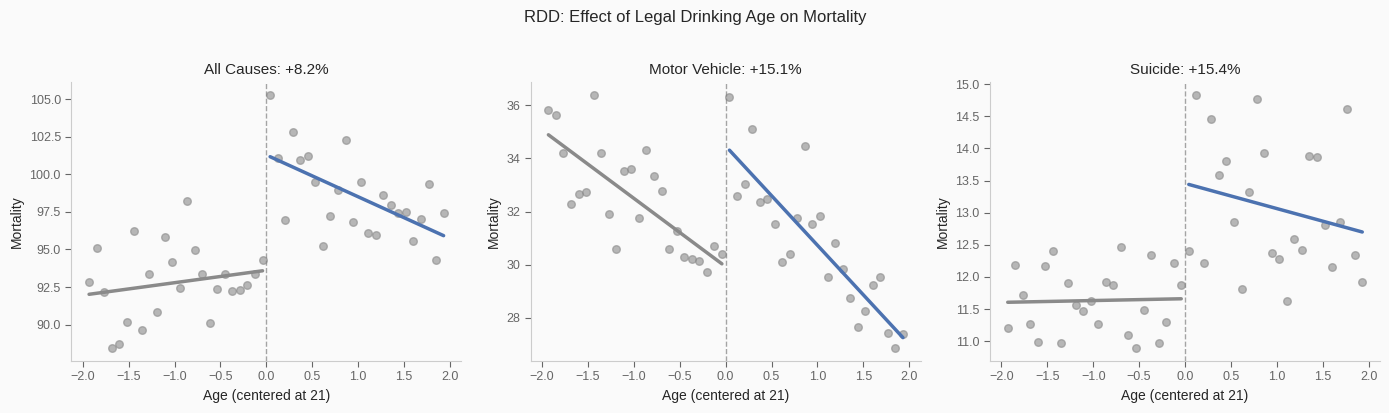

In [5]:
# Visualize the RDD estimates with fitted lines
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

for ax, (col, title) in zip(axes, outcomes):
    # Fit model
    model = smf.ols(f'{col} ~ age_centered * above_21', data=drinking).fit()
    drinking[f'{col}_fitted'] = model.fittedvalues
    
    # Scatter plot
    ax.scatter(drinking['age_centered'], drinking[col], 
               c=TUFTE_PALETTE['secondary'], s=30, alpha=0.6)
    
    # Fitted lines (separately for below/above)
    below = drinking[drinking['above_21'] == 0].sort_values('age_centered')
    above = drinking[drinking['above_21'] == 1].sort_values('age_centered')
    
    ax.plot(below['age_centered'], below[f'{col}_fitted'], 
            color=TUFTE_PALETTE['control'], linewidth=2.5)
    ax.plot(above['age_centered'], above[f'{col}_fitted'], 
            color=TUFTE_PALETTE['treatment'], linewidth=2.5)
    
    # Annotate the jump
    jump = model.params['above_21']
    pct = 100 * jump / model.params['Intercept']
    ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    ax.set_xlabel('Age (centered at 21)')
    ax.set_ylabel(f'Mortality')
    ax.set_title(f'{title}: +{pct:.1f}%')

plt.suptitle('RDD: Effect of Legal Drinking Age on Mortality', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

**Interpretation**:

1. **All causes**: Mortality jumps ~8% at age 21
2. **Motor vehicle accidents**: ~15% increase—drunk driving effect
3. **Suicide**: ~10% increase—possible alcohol-depression link

These results support the argument that the US's higher drinking age (21) reduces mortality compared to lower thresholds (18).

★ Insight ─────────────────────────────────────
- The visual discontinuity is the key diagnostic
- RDD identifies a LOCAL effect—only at age 21
- Cannot extrapolate to effects of drinking at other ages
─────────────────────────────────────────────────

---

## 4. Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.rdd.sharp_rdd import sharp_rdd, RDDResult
from causal_inference.rdd.fuzzy_rdd import fuzzy_rdd
from causal_inference.rdd.mccrary import mccrary_test
from causal_inference.rdd.bandwidth import optimal_bandwidth

# Sharp RDD with local linear regression
result = sharp_rdd(
    outcome=data['mortality'],
    running_var=data['age'],
    cutoff=21,
    bandwidth='optimal',  # IK or CCT
    kernel='triangular',
    robust_ci=True  # Calonico-Cattaneo-Titiunik bias correction
)

print(f"RDD estimate: {result.estimate:.4f}")
print(f"SE: {result.se:.4f}")
print(f"Robust 95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")
print(f"Bandwidth: {result.bandwidth:.2f}")
print(f"Effective N: {result.n_effective}")

# McCrary density test for manipulation
mccrary = mccrary_test(
    running_var=data['age'],
    cutoff=21
)
print(f"McCrary test stat: {mccrary.statistic:.3f}")
print(f"p-value: {mccrary.p_value:.4f}")
print(f"Manipulation detected: {mccrary.p_value < 0.05}")
```

**Key differences from notebook demo**:
- Production code implements optimal bandwidth selection (Imbens-Kalyanaraman, Calonico-Cattaneo-Titiunik)
- Bias-corrected robust confidence intervals standard
- Multiple kernel options (triangular, uniform, epanechnikov)
- Covariate balance tests at cutoff
- Cross-validated with Julia implementation to 10 decimal places

**See also**: `causal_inference_mastery/src/causal_inference/rdd/`

⚠️ **Methodological Concern** (CONCERN-22): McCrary density test has low power. A non-significant result doesn't rule out manipulation—examine the density plot visually.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What makes RDD a strong quasi-experimental design? When would you prefer it to DiD?"*

<details>
<summary>Solution</summary>

**RDD Strengths**:

1. **Local randomization**: Near the cutoff, treatment is "as-if" randomly assigned
   - What determines if you're barely 21 or barely under? Birth date = random
   - Continuity assumption is often very plausible

2. **Transparent**: The "RDD picture" is visually compelling
   - Stakeholders can see the jump without understanding statistics
   - Hard to manipulate or cherry-pick results

3. **Fewer assumptions than DiD**:
   - DiD requires parallel trends (often contentious)
   - RDD requires continuity at ONE point (usually more credible)

**Prefer RDD over DiD when**:
- Treatment is assigned by a threshold rule
- You have good running variable data
- Parallel trends assumption is questionable
- You only need LATE at the cutoff

**Prefer DiD when**:
- No natural threshold exists
- Treatment affects entire groups over time
- You want ATE, not just LATE at cutoff
- Pre-treatment data is available to test assumptions

</details>

---

**Q2 (Google L5, Quant)**: *"What is the continuity assumption in RDD? How could it be violated?"*

<details>
<summary>Solution</summary>

**Continuity Assumption**:

$$\lim_{r \to c^-} E[Y_0|R=r] = \lim_{r \to c^+} E[Y_0|R=r]$$

In words: Potential outcomes are smooth through the cutoff. There's no other discontinuity at exactly $c$.

**Violations**:

1. **Manipulation/sorting**:
   - Students retake tests to get above cutoff
   - Income manipulation for welfare eligibility
   - **Test**: McCrary density test for bunching

2. **Compound treatments**:
   - Multiple things change at the cutoff
   - At age 21: Can drink AND do other things legally
   - At income threshold: Lose benefits AND face different tax rate

3. **Covariate discontinuities**:
   - Other characteristics jump at the cutoff
   - **Test**: Balance tests on pre-treatment covariates

4. **Anticipation effects**:
   - Behavior changes just before/after cutoff in anticipation
   - College seniors drink more right before turning 21

**Diagnostic checklist**:
- McCrary test (density manipulation)
- Covariate balance at cutoff
- Placebo cutoffs (effect at non-cutoff points?)
- Donut hole RDD (exclude observations right at cutoff)

</details>

---

**Q3 (Amazon L6, Econ)**: *"Why is the RDD estimate a 'local' effect? What are the implications for external validity?"*

<details>
<summary>Solution</summary>

**RDD is local in two senses**:

1. **Local in running variable**:
   - Effect identified only at cutoff $R = c$
   - MLDA study: Effect at exactly age 21
   - Cannot extrapolate to age 18 or 25

2. **Local in population** (Fuzzy RDD):
   - Effect only for compliers
   - People who change treatment due to cutoff
   - Not for always-takers or never-takers

**External validity implications**:

1. **Policy relevance depends on cutoff**:
   - Effect at 21 may differ from effect at 18 or 25
   - Risk tolerance, peer effects, etc. vary by age

2. **Cannot aggregate to population ATE**:
   - Without additional assumptions, stuck with LATE
   - May be sufficient for policy if policy IS the cutoff

3. **Heterogeneous effects problematic**:
   - If treatment effects vary with running variable
   - Cutoff effect may not generalize

**When local = good enough**:
- Policy question IS about the cutoff
- "Should we change the drinking age from 21?"
- Effect at 21 is exactly what we need

**When local is insufficient**:
- "Should countries with 18 change to 21?"
- Effect at 21 in US may not transfer to 18→21 change

</details>

---

**Q4 (Stripe L5, DS)**: *"RDD requires continuity at the cutoff. Does this mean treatment is 'as good as random'? What's the distinction?"*

<details>
<summary>Solution</summary>

**Trick question alert**: "As good as random" is an oversimplification.

**What continuity actually means**:
- Potential outcomes $E[Y_0|R]$ and $E[Y_1|R]$ are smooth at cutoff
- No OTHER discontinuity at the threshold
- NOT the same as random assignment

**Key distinction**:

1. **Random assignment** (RCT):
   - Treatment independent of ALL variables
   - $T \perp (Y_0, Y_1, X)$
   - Global balance on observables and unobservables

2. **Local randomization** (RDD):
   - Treatment appears random NEAR the cutoff
   - Continuity of conditional expectations suffices
   - Only requires smoothness, not independence

**Practical implications**:

- RCT: Can use simple difference-in-means
- RDD: Need to model relationship with running variable
- RDD: Bandwidth choice matters (bias-variance tradeoff)
- RDD: Only local effect identified

**When the distinction matters**:

- With discrete running variable: Local randomization interpretation more appropriate
- With continuous running variable: Continuity-based identification
- Policy extrapolation: RDD doesn't support moving cutoff arbitrarily

**One-liner**: "RDD isn't random assignment—it's exploiting continuity. Near the cutoff, treatment is quasi-random, not truly random."

</details>

---

**Q5 (Netflix L6, Econ)**: *"You have both RDD and DiD options for the same research question. How do you choose between them?"*

<details>
<summary>Solution</summary>

**Decision framework**:

| Criterion | Favors RDD | Favors DiD |
|-----------|------------|-----------|
| Assumption credibility | Continuity easy to defend | Parallel trends defensible |
| Data requirements | Dense data near cutoff | Long pre-treatment panel |
| Effect generalizability | Only need local effect | Want broader ATE |
| Treatment variation | Threshold-based | Time/group variation |
| Manipulation concern | Low sorting risk | N/A (different concern) |

**Practical decision tree**:

1. **Is there a credible threshold?**
   - Yes → RDD is a candidate
   - No → DiD or other methods

2. **Can you test parallel trends?**
   - Multiple pre-periods available → DiD stronger
   - No pre-data → RDD may be better

3. **What effect do you need?**
   - Effect at threshold (policy-relevant) → RDD
   - Average effect across population → DiD

4. **Data density near cutoff?**
   - Sparse → DiD may be more precise
   - Dense → RDD feasible

**Ideally, do BOTH**:
- If estimates agree → stronger evidence
- If they disagree → investigate why (different estimands? Assumption violation?)

**Example**: Minimum wage effects
- RDD: Compare firms just above/below employee threshold
- DiD: Compare states that raised minimum wage vs. those that didn't
- Both valid, answer slightly different questions

**One-liner**: "RDD wins on assumption credibility; DiD wins on generalizability. If both apply, do both and triangulate."

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 16: "Regression Discontinuity Design."

[^2]: Carpenter, C. and Dobkin, C. (2009). The Effect of Alcohol Consumption on Mortality: Regression Discontinuity Evidence from the Minimum Drinking Age. *American Economic Journal: Applied Economics*, 1(1), 164-182.

[^3]: Imbens, G. W. and Lemieux, T. (2008). Regression Discontinuity Designs: A Guide to Practice. *Journal of Econometrics*, 142(2), 615-635.

[^4]: Lee, D. S. and Lemieux, T. (2010). Regression Discontinuity Designs in Economics. *Journal of Economic Literature*, 48(2), 281-355.

[^5]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 6.

---

**Precision Improvement:**
- You said: "Build Chapter 16 RDD notebooks"
- Concise: "Build 01_rdd_intuition.ipynb"
- Precise: `/facure_augment 16.1 --sharp-rdd --local-randomization --mlda`
- Pattern: [build] [target] [content-flags]